# Prelude

In [1]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import pandas
import numpy
import itertools
import matplotlib
import seaborn
import textwrap

from matplotlib.ticker import *

from matplotlib import pyplot
from matplotlib.ticker import FixedLocator, AutoLocator, FuncFormatter, MultipleLocator, IndexLocator

from pandas import Series, DataFrame, Index

seaborn.set()

# Getting Data

In [2]:
llama = pandas.read_csv('outputs/llama.csv', index_col = 'Num')
bigllama = pandas.read_csv('outputs/llama-70b.csv', index_col = 'Num')

In [55]:
gemma = pandas.read_csv('outputs/gemma.csv', index_col = 'Num')
biggemma = pandas.read_csv('outputs/gemma-27b.csv', index_col = 'Num')

In [56]:
flan = pandas.read_csv('outputs/flan-t5-xl.csv', index_col = 'Num')
bigflan = pandas.read_csv('outputs/flan-t5-xxl.csv', index_col = 'Num')

# Parsing Data

# New plots

In [3]:
def cool_line(left, right, ax = None, cleft = None, cright = None, **kwargs):
    if ax is None:
        ax = pyplot.gca()

    ax.set_xticks([0, 1])
    ax.set_xticklabels(['[]', '[ctx]'])
    # ax.set_ylim(0 - .05, 1 + .05)

    kwargs['alpha'] = .75
    kwargs['color'] = cleft or kwargs['color']
    kwargs['zorder'] = zorders[kwargs['color']]
    ax.scatter([0], [left], **kwargs)

    kwargs['color'] = cright or kwargs['color']
    kwargs['zorder'] = zorders[kwargs['color']]
    ax.scatter([1], [right], **kwargs)

    kwargs['color'] = 'black'
    kwargs['alpha'] = 1
    kwargs['linewidth'] = .2
    kwargs['zorder'] = 1
    ax.plot([0, 1], [left, right], **kwargs)

In [42]:
palette = seaborn.color_palette('hls', 3)
colors = {
    'Parametric': palette[1],
    'Counterfactual': palette[0],
    'Other': palette[2],
}
zorders = {
    colors['Parametric']: 5,
    colors['Counterfactual']: 4,
    colors['Other']: 6,
}

def getPlots(table, title = None, axs = None):
    if axs is None:
        fig, axs = pyplot.subplots(
            ncols = 3,
            squeeze = True,
            sharey = True,
        )
        if title:
            fig.suptitle(title, fontsize = 12)

    top = 0
    bot = 100

    a = table.rename(columns = lambda x: x.split('-', 1)[0])
    for _, row in a.iterrows():
        cright = colors[row.comparison]

        base_proba = row.base_proba
        base_cf_proba = row.base_cf_proba
        ctx_proba = row.ctx_proba
        ctx_param_proba = row.ctx_param_proba
        ctx_cf_proba = row.ctx_cf_proba

        cool_line(base_proba, ctx_param_proba, axs[0], color = colors['Parametric'])
        cool_line(base_proba, ctx_proba, axs[1], cleft = colors['Parametric'], cright = cright)
        cool_line(base_cf_proba, ctx_cf_proba, axs[2], color = colors['Counterfactual'])

        top = max(top, base_proba, base_cf_proba, ctx_proba, ctx_param_proba, ctx_cf_proba)
        bot = min(bot, base_proba, base_cf_proba, ctx_proba, ctx_param_proba, ctx_cf_proba)

    axs[0].set_ylabel('Cross-Entropy', fontsize = 9)
    # axs[0].set_ylim(bot - (top - bot) * .04, top + (top - bot) * .04)
    # axs[1].set_ylim(bot - (top - bot) * .04, top + (top - bot) * .04)
    # axs[2].set_ylim(bot - (top - bot) * .04, top + (top - bot) * .04)
    for ax in axs:
        ax.set_ylim(bot - (top - bot) * .04, top + (top - bot) * .04)
        # ax.set_yscale('log')

    # axs[0].yaxis.set_major_locator(MultipleLocator(.2))
    # axs[0].yaxis.set_major_formatter(lambda x, _: f'{x:.0%}')
    # axs[1].yaxis.set_major_formatter(NullFormatter())
    # axs[2].yaxis.set_major_formatter(NullFormatter())

In [43]:
def barPlot(table, ax):
    ax.set_ylim(0, table.shape[0])
    ax.bar(
        range(3),
        [(table.comparison == x).sum() for x in colors.keys()],
        color = colors.values(),
        tick_label = ['', '', ''],
    )

In [44]:
def generateTables(*tables, head = None):
    for question, table in itertools.islice(tables[0].groupby('Base_Question'), head):
        ix = table.index

        fig, axs = pyplot.subplots(ncols = 4, nrows = len(tables), width_ratios = [1, 1, 1, 2], squeeze = False, figsize = (8, 3 * len(tables)))
        fig.tight_layout(rect = [0, .05, 1, .97])
        fig.suptitle(question, fontsize = 12)

        for e, df in enumerate(tables):
            df_part = df.loc[ix].rename(columns = lambda x: x.split('-', 1)[0])
            getPlots(df_part, axs = axs[e])
            barPlot(df_part, ax = axs[e][3])

        for name, color in colors.items():
            pyplot.scatter([], [], label = name, color = color)

        pyplot.legend(ncols = 3, bbox_to_anchor = [0, -.2])
        pyplot.show()

        # fig.savefig(f'figures/df_{ix[0]}.png', dpi = 300, pad_inches = 0, bbox_inches = 'tight')


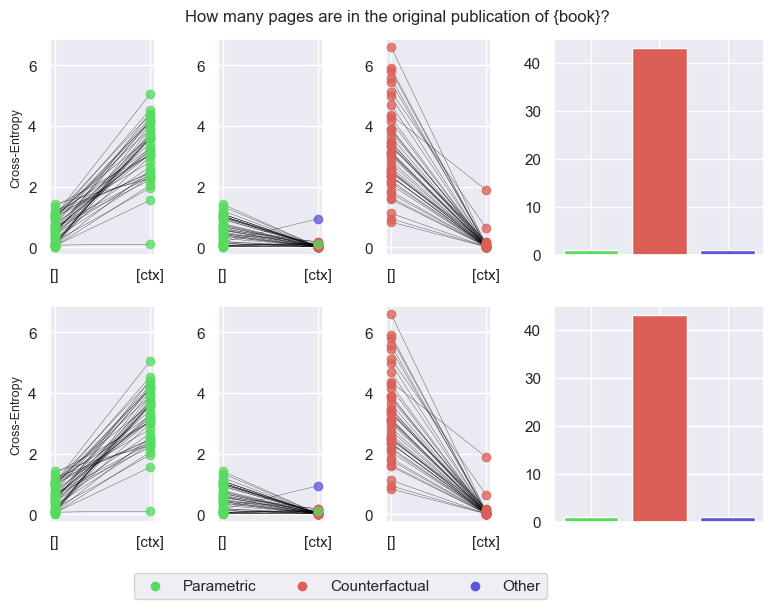

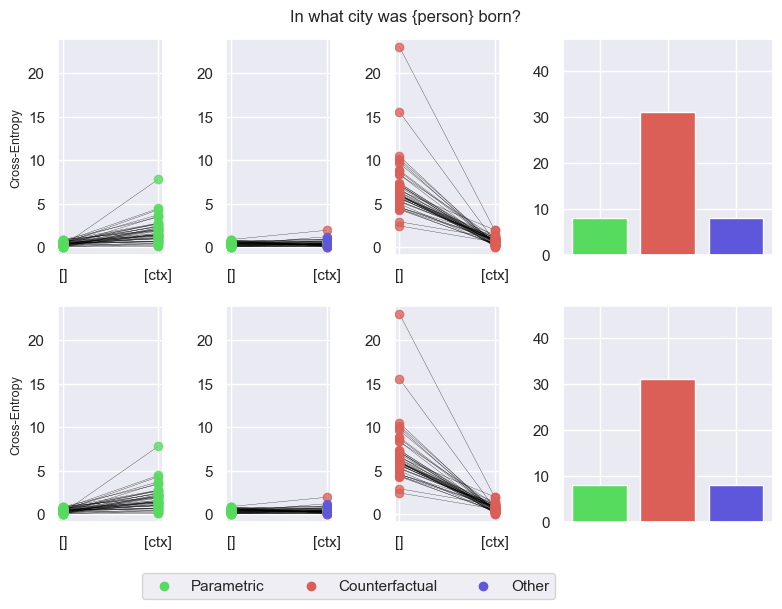

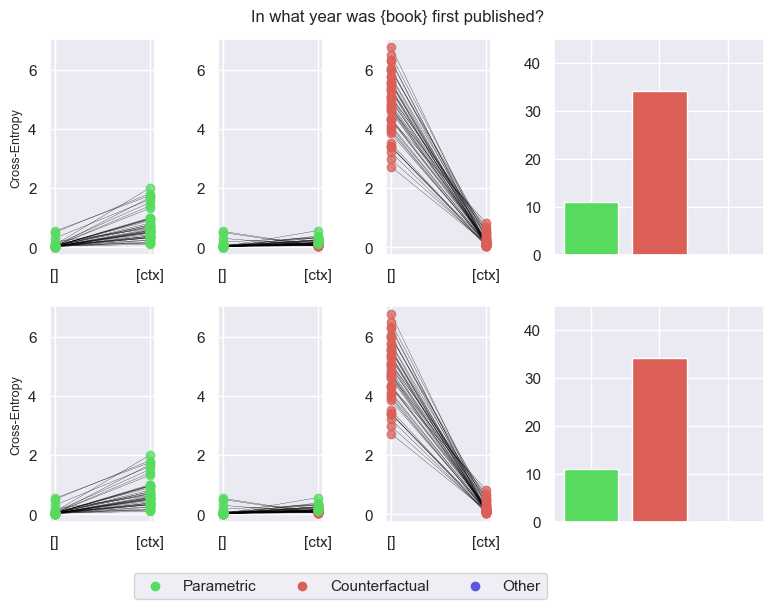

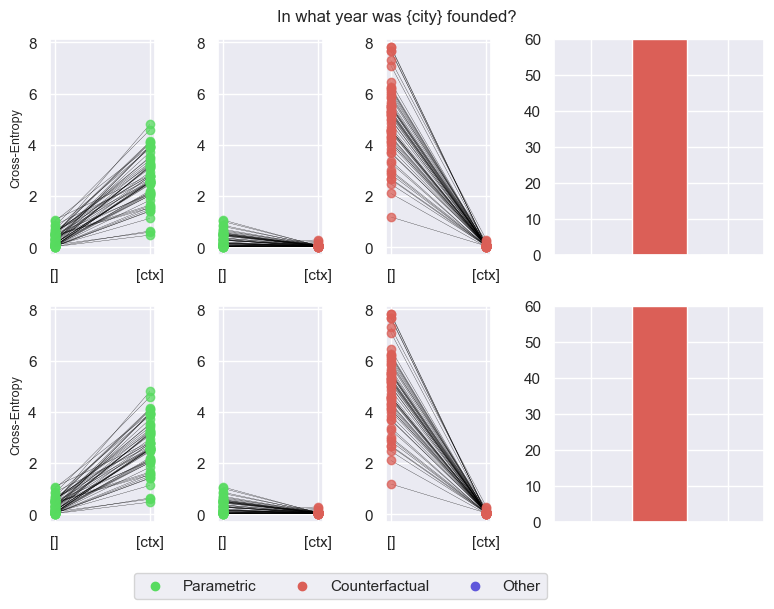

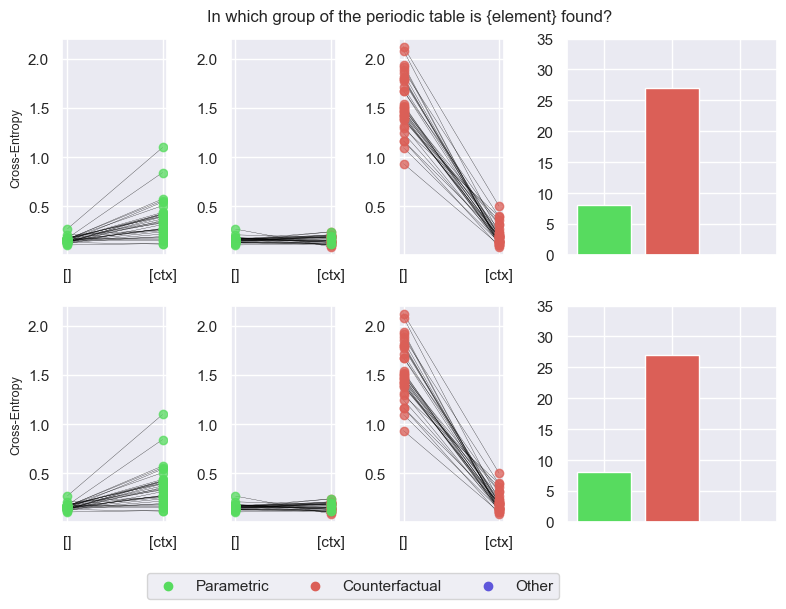

In [45]:
generateTables(llama, llama, head = 5)

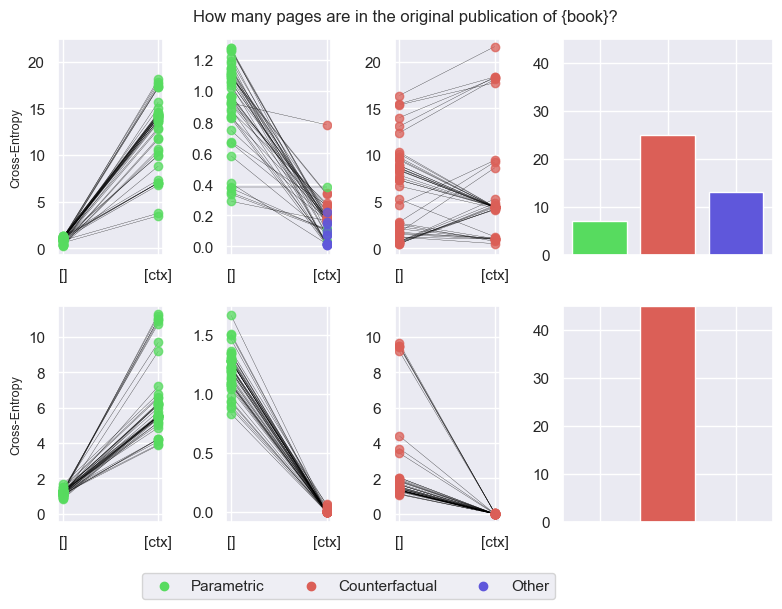

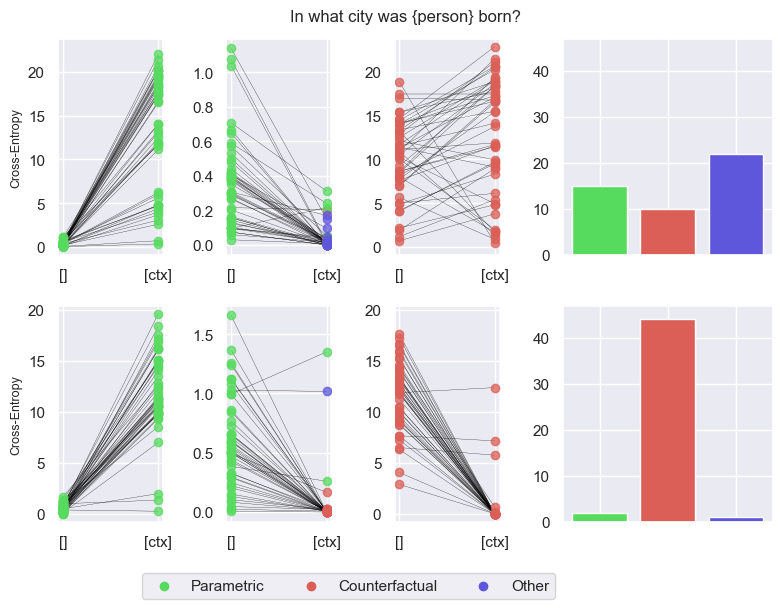

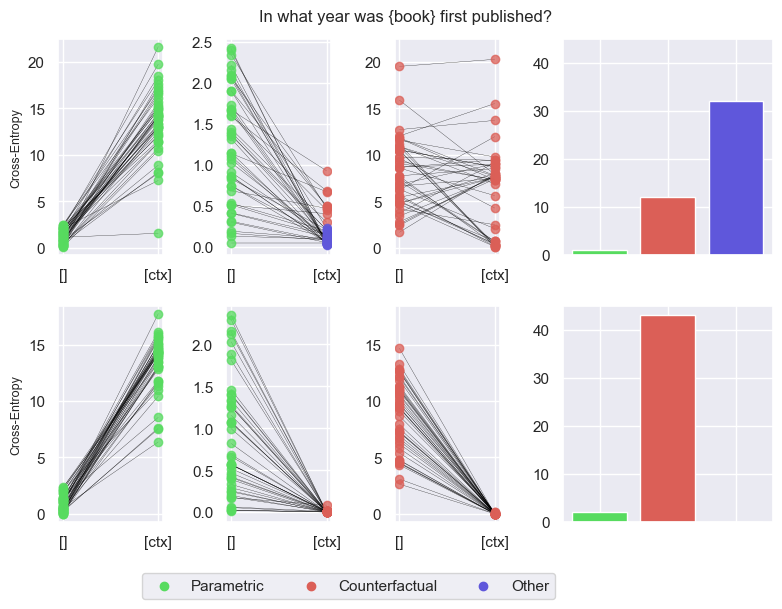

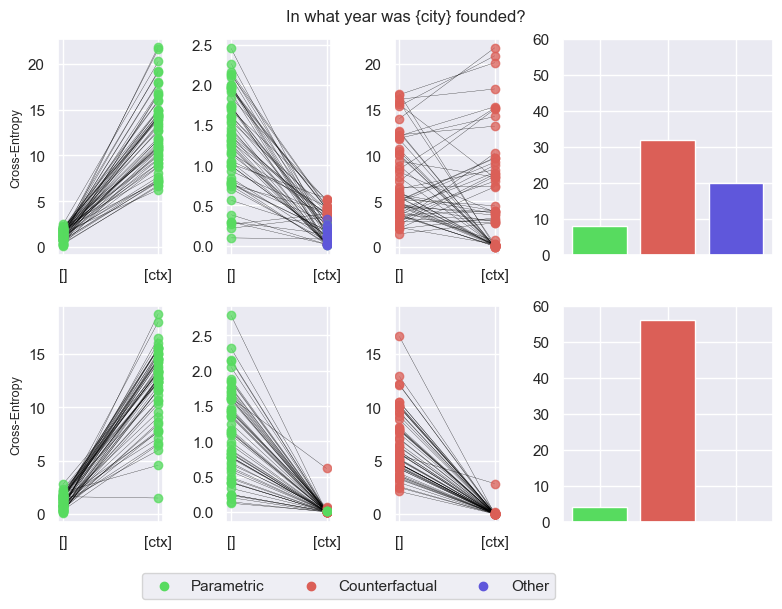

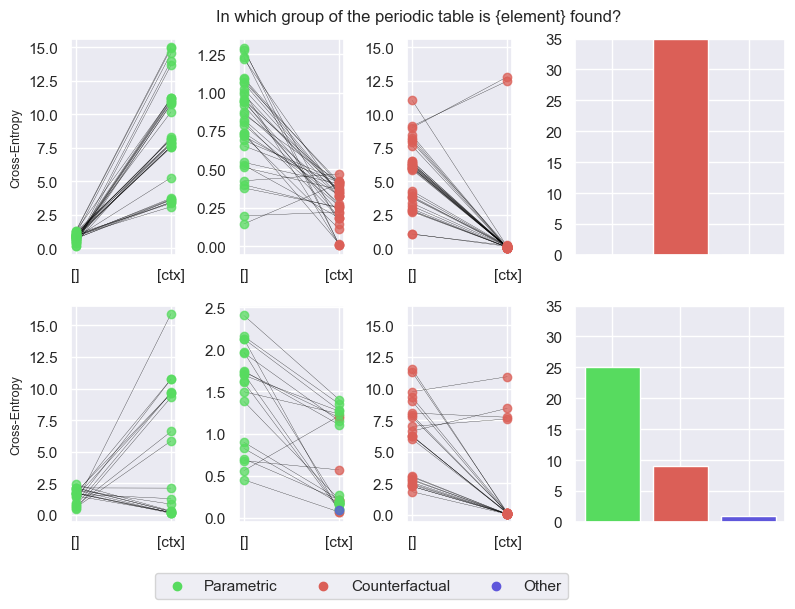

In [111]:
generateTables(flan, bigflan, head = 5)

# Analysis

## Others

In [59]:
llama.columns

Index(['Category', 'Base_Question', 'Thing', 'Question', 'Prefix',
       'parametric-llama', 'base_proba-llama', 'base_cf_proba-llama',
       'counterfactual-llama', 'contextual-llama', 'ctx_proba-llama',
       'ctx_param_proba-llama', 'ctx_cf_proba-llama', 'comparison-llama'],
      dtype='object')

In [66]:
llama.groupby('Base_Question')['comparison-llama'].apply(lambda x: (x == 'Other').sum()).sort_values(ascending = False).head()

Base_Question
What's the highest administrative subdivision {city} is part of?    11
In what city was {person} born?                                      8
What is the time zone of {city}?                                     3
What's the main nationality of {person}?                             2
Who was the primary leader associated with {historical_event}?       2
Name: comparison-llama, dtype: int64

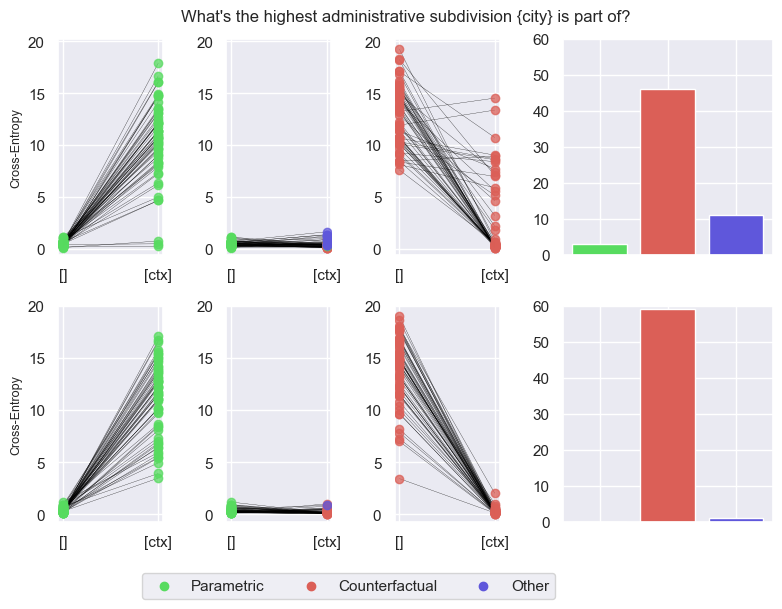

,Thing,parametric-llama,counterfactual-llama,contextual-llama,comparison-llama
Num,,,,,
389,Alexandria,the Governorate of Alexandria,the Western Cape province,the City of Cape Town,Other
396,Bukhara,Uzbekistan,the country of Georgia,Georgia,Other
399,Cartagena,Bolívar Department,the Kantō region,Ibaraki Prefecture,Other
413,London,the Greater London administrative area which i...,Uzbekistan,the region of London,Other
423,Paris,the Île-de-France region,Iraq,Baghdad Governorate,Other
424,Petra,the Ma'an Governorate,the State of Israel and the Palestinian territ...,South District,Other
434,Sydney,the state of New South Wales,the state of Maharashtra and the country of India,a district,Other
435,Tbilisi,the country of Georgia,the state of Maharashtra and the country of India,a district,Other
438,Timbuktu,Mali,Uttar Pradesh,a district,Other


In [77]:
indexes = llama.Base_Question == "What's the highest administrative subdivision {city} is part of?"
generateTables(llama[indexes], bigllama[indexes])
llama[indexes & (llama['comparison-llama'] == 'Other')][['Thing', 'parametric-llama', 'counterfactual-llama', 'contextual-llama', 'comparison-llama']]

In [85]:
bigllama.columns

Index(['Category', 'Base_Question', 'Thing', 'Question', 'Prefix',
       'parametric-llama-70b', 'base_proba-llama-70b',
       'base_cf_proba-llama-70b', 'counterfactual-llama-70b',
       'contextual-llama-70b', 'ctx_proba-llama-70b',
       'ctx_param_proba-llama-70b', 'ctx_cf_proba-llama-70b',
       'comparison-llama-70b'],
      dtype='object')

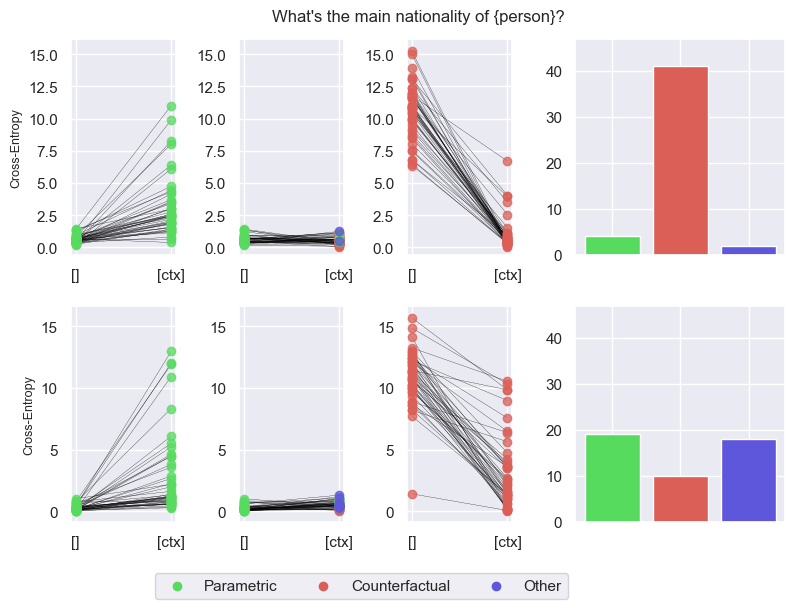

,Thing,parametric-llama,counterfactual-llama,contextual-llama,comparison-llama
Num,,,,,
250,Greta Thunberg,Swedish,a Muslim from Mali,a Swedish nationality,Other
264,Muhammad Ali,American,a Muslim from Mali,a Malian,Other


,Thing,parametric-llama-70b,counterfactual-llama-70b,contextual-llama-70b,comparison-llama-70b
Num,,,,,
235,Ada Lovelace,British,Russian,not Russian,Other
237,Albert Einstein,German,Serbian,not Serbian,Other
241,Boyan Slat,Dutch,Iranian,"not Iranian, he is Dutch",Other
242,Catherine the Great,German,Italian,Russian,Other
246,Ernest Rutherford,New Zealand-born British,a Malian,a New Zealander,Other
248,Freddie Mercury,Parsi,German,not German he is British of Parsi descent,Other
250,Greta Thunberg,Swedish,a Malian,not Malian,Other
252,Ibn al-Haytham,Arab,Russian,not Russian,Other
257,Malala Yousafzai,Pakistani,Indian,not Indian,Other


In [86]:
indexes = llama.Base_Question == "What's the main nationality of {person}?"
generateTables(llama[indexes], bigllama[indexes])
display(llama[indexes & (llama['comparison-llama'] == 'Other')][['Thing', 'parametric-llama', 'counterfactual-llama', 'contextual-llama', 'comparison-llama']])
display(bigllama[indexes & (bigllama['comparison-llama-70b'] == 'Other')][['Thing', 'parametric-llama-70b', 'counterfactual-llama-70b', 'contextual-llama-70b', 'comparison-llama-70b']])

In [82]:
display

<function IPython.core.display_functions.display(*objs, include=None, exclude=None, metadata=None, transient=None, display_id=None, raw=False, clear=False, **kwargs)>

# Questions

In [15]:
questions = pandas.read_csv('outputs/llama.csv')

In [29]:
questions[questions.Base_Question.str.startswith('Which scientific discipline')]

,Num,Category,Base_Question,Thing,Question,Prefix,parametric-llama,base_proba-llama,counterfactual-llama,base_cf_proba-llama,contextual-llama,ctx_proba-llama,ctx_param_proba-llama,ctx_cf_proba-llama,comparison-llama
779,779,principle,Which scientific discipline encompasses {princ...,Archimedes' Principle,Which scientific discipline encompasses Archim...,Archimedes' Principle is encompassed by,the scientific discipline of physics,0.797335,1609,2.891705e-04,Physics,0.319553,0.012617,0.016337,Other
780,780,principle,Which scientific discipline encompasses {princ...,Bernoulli's Principle,Which scientific discipline encompasses Bernou...,Bernoulli's Principle is encompassed by,the scientific discipline of fluid dynamics,0.732627,to create a copy of the original DNA molecule,8.828898e-06,fluid dynamics,0.527540,0.121592,0.012314,Other
781,781,principle,Which scientific discipline encompasses {princ...,Boyle's Law,Which scientific discipline encompasses Boyle'...,Boyle's Law is encompassed by,the scientific discipline of physics,0.789325,1820,3.310547e-04,physics,0.349356,0.010818,0.025988,Other
782,782,principle,Which scientific discipline encompasses {princ...,Cell Theory,Which scientific discipline encompasses Cell T...,Cell Theory is encompassed by,the scientific discipline of Biology,0.733449,the prevention and treatment of infectious dis...,6.884726e-02,the prevention and treatment of infectious dis...,0.693902,0.088401,0.866785,Counterfactual
783,783,principle,Which scientific discipline encompasses {princ...,Conservation of Energy,Which scientific discipline encompasses Conser...,Conservation of Energy is encompassed by,the scientific discipline of Physics,0.742158,the scientific discipline of quantum mechanics,5.431405e-01,the scientific discipline of quantum mechanics,0.881664,0.698488,0.881664,Counterfactual
784,784,principle,Which scientific discipline encompasses {princ...,DNA Replication,Which scientific discipline encompasses DNA Re...,DNA Replication is encompassed by,the scientific discipline of Molecular Biology,0.740432,to create a copy of the original DNA molecule,5.022784e-03,Molecular Biology,0.523550,0.017892,0.002269,Other
785,785,principle,Which scientific discipline encompasses {princ...,Electromagnetism,Which scientific discipline encompasses Electr...,Electromagnetism is encompassed by,the scientific discipline of Physics,0.767108,Microbiology,1.314475e-06,Microbiology,0.922353,0.001507,0.922353,Counterfactual
786,786,principle,Which scientific discipline encompasses {princ...,Entropy,Which scientific discipline encompasses Entropy?,Entropy is encompassed by,the scientific discipline of Thermodynamics,0.809361,Nicolaus Copernicus,2.770753e-08,Physics,0.411909,0.003023,0.006736,Other
787,787,principle,Which scientific discipline encompasses {princ...,Evolution by Natural Selection,Which scientific discipline encompasses Evolut...,Evolution by Natural Selection is encompassed by,the scientific discipline of Biology,0.816824,Gregor Mendel,3.447979e-07,Genetics,0.246063,0.008684,0.051979,Other
788,788,principle,Which scientific discipline encompasses {princ...,Evolution,Which scientific discipline encompasses Evolut...,Evolution is encompassed by,the scientific discipline of Biology,0.761451,the scientific discipline of Physics,6.458675e-01,the scientific discipline of Physics,0.824130,0.756913,0.824130,Counterfactual
